In [1]:
!pip install openpyxl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import openpyxl

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor,BaggingRegressor,ExtraTreesRegressor,GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score

%matplotlib inline
from plotly.offline import iplot, init_notebook_mode
import plotly.express as px
init_notebook_mode(connected=True)

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [3]:
df = pd.read_excel('/content/Data_Train.xlsx')

In [4]:
df.head(3)

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882


In [5]:
df[df.isnull().any(axis=1)]

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
9039,Air India,6/05/2019,Delhi,Cochin,NaN,09:45,09:25 07 May,23h 40m,NaN,No info,7480


In [6]:
df['Airline'].value_counts()

Airline
Jet Airways                          3849
IndiGo                               2053
Air India                            1752
Multiple carriers                    1196
SpiceJet                              818
Vistara                               479
Air Asia                              319
GoAir                                 194
Multiple carriers Premium economy      13
Jet Airways Business                    6
Vistara Premium economy                 3
Trujet                                  1
Name: count, dtype: int64

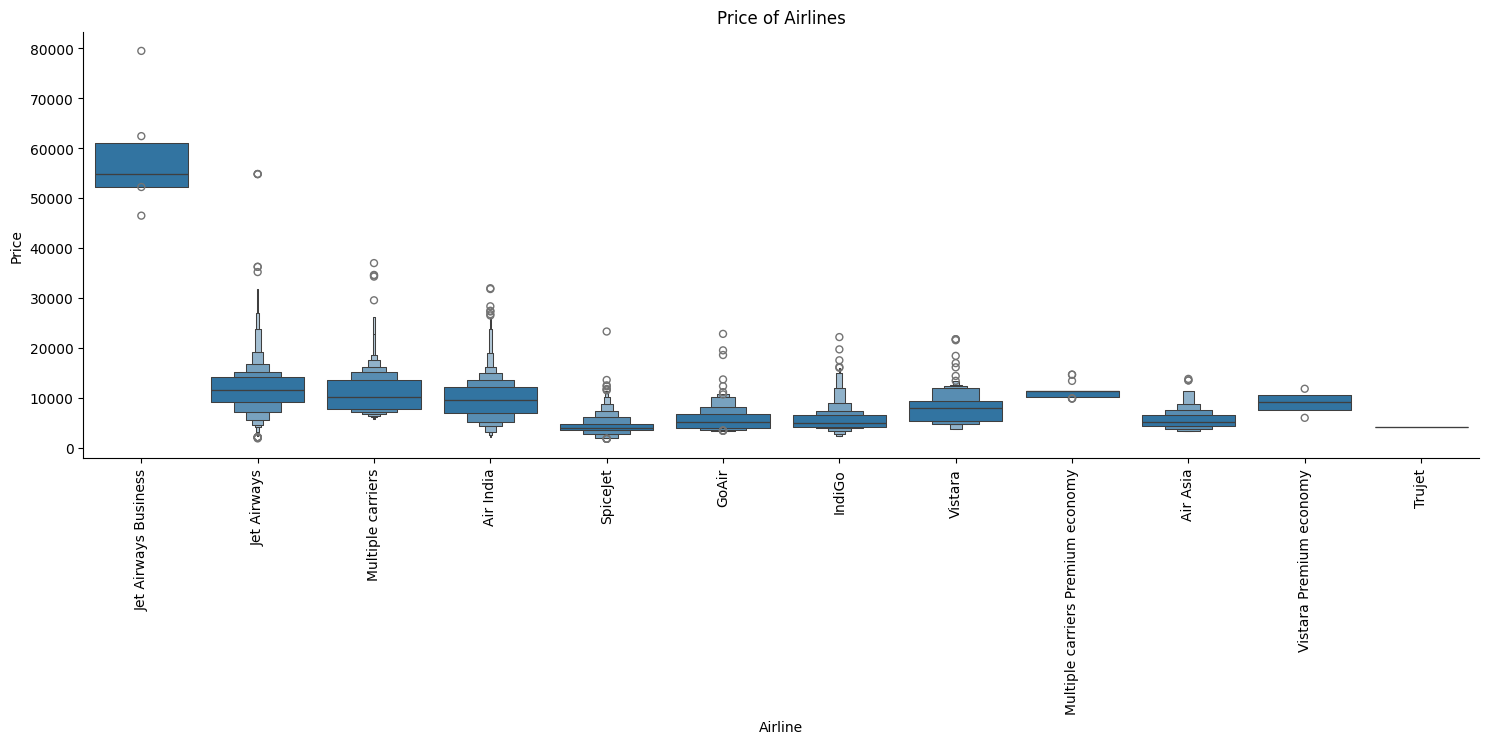

In [7]:
sns.catplot(x = 'Airline',y='Price',data= df.sort_values(by='Price',ascending=False),kind='boxen',height=5,aspect=3)
plt.xticks(rotation=90)
plt.title('Price of Airlines')
plt.show()

In [8]:
df['Additional_Info'] = df['Additional_Info'].apply(lambda x: 2 if x =='Business class' else (1 if x == 'No info' else 0))

In [9]:
ls = ['Multiple carriers Premium economy','Jet Airways Business', 'Vistara Premium economy', 'Trujet']
df['Airline'] = df['Airline'].apply(lambda x: x if x not in ls else 'Other')

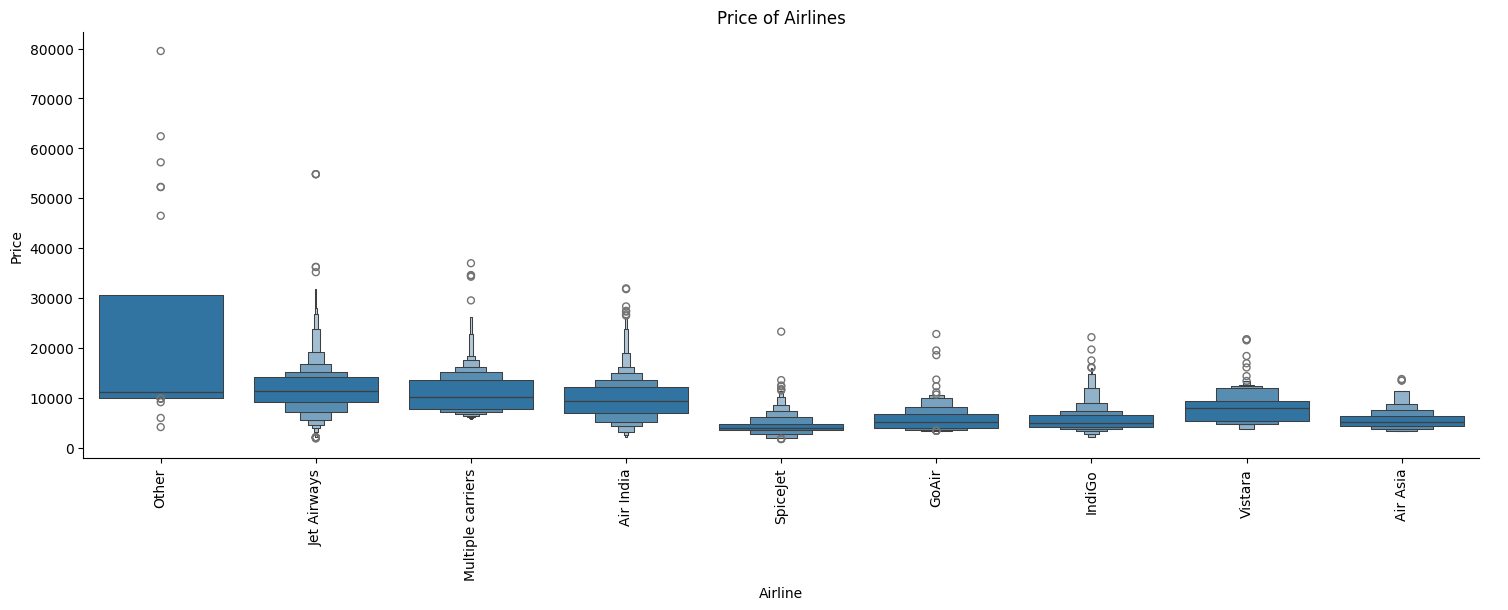

In [10]:
sns.catplot(x = 'Airline',y='Price',data= df.sort_values(by='Price',ascending=False),kind='boxen',height=5,aspect=3)
plt.xticks(rotation=90)
plt.title('Price of Airlines')
plt.show()

<Axes: ylabel='Price'>

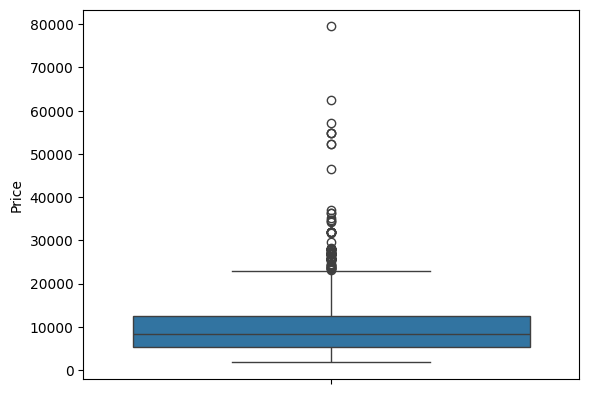

In [11]:
df.dropna(inplace=True)
sns.boxplot(df['Price'])

<Axes: ylabel='Price'>

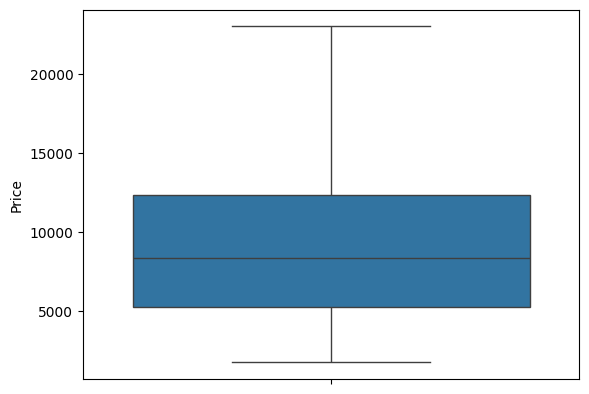

In [12]:
def outliers_detect(data):
    q1=df[data].quantile(0.25)
    q3=df[data].quantile(0.75)
    iqr = q3-q1
    lower_value = q1-1.5*iqr
    upper_value = q3+1.5*iqr
    return lower_value,upper_value

low,high = outliers_detect('Price')

df['Price'] = df['Price'].apply(lambda x: x if x <= high else high).astype(int)
sns.boxplot(df['Price'])

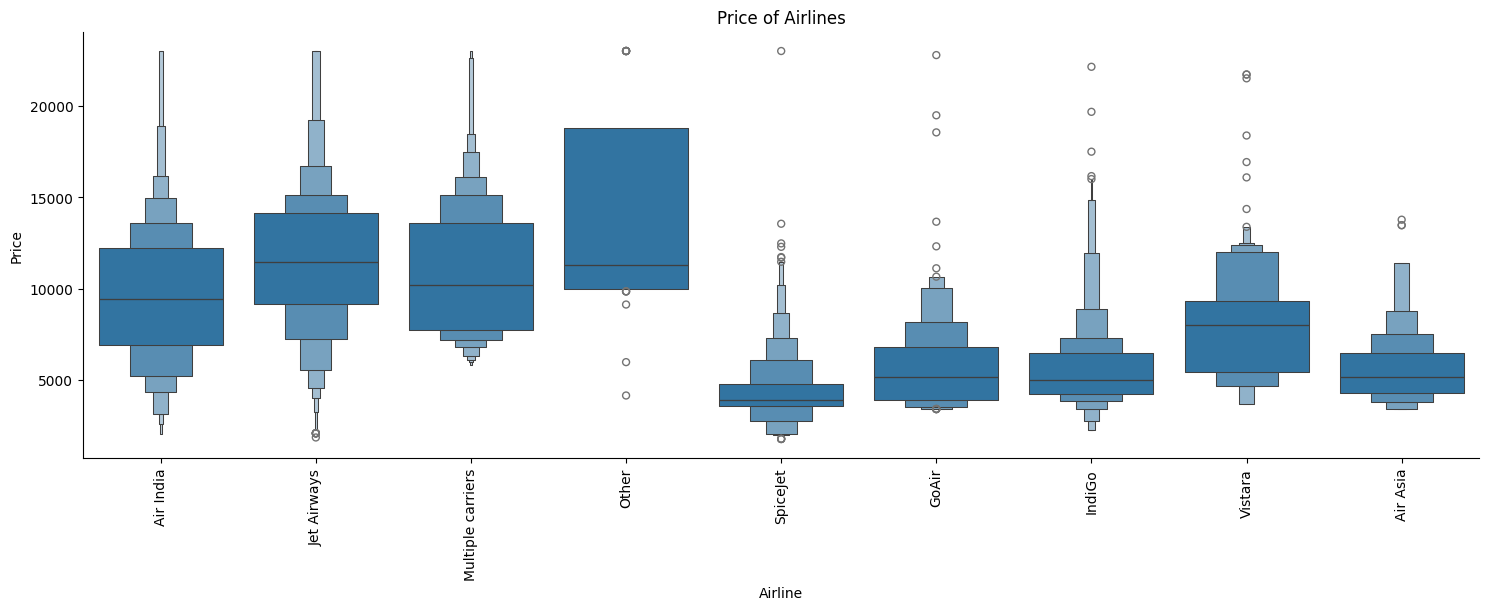

In [13]:
sns.catplot(x = 'Airline',y='Price',data= df.sort_values(by='Price',ascending=False),kind='boxen',height=5,aspect=3)
plt.xticks(rotation=90)
plt.title('Price of Airlines')
plt.show()

In [14]:
# Check if the DataFrame is loaded
if df is None:
    raise ValueError("DataFrame 'df' is not loaded.")

In [15]:
df['Date_of_Journey'] = pd.to_datetime(df['Date_of_Journey'])

df['DOJ_year']=df['Date_of_Journey'].dt.year

df['DOJ_month']=df['Date_of_Journey'].dt.month

df['DOJ_month_name']=df['Date_of_Journey'].dt.month_name()

df['Day']=df['Date_of_Journey'].dt.day

df['DOJ_day_name']=df['Date_of_Journey'].dt.day_name()

df['DOJ_week_no']=df['Date_of_Journey'].dt.isocalendar().week # deprecated
df['Week of Year'] = df['Date_of_Journey'].dt.isocalendar()['week']
import pandas as pd

def extract_duration(duration_str, part='hour'):
    if pd.isna(duration_str):
        return 0

    parts = duration_str.split(' ')
    if part == 'hour':
        hour_part = next((p for p in parts if 'h' in p), None)  # Find the part with 'h'
        return int(hour_part.replace('h', '')) if hour_part else 0
    elif part == 'minute':
        min_part = next((p for p in parts if 'm' in p), None)  # Find the part with 'm'
        return int(min_part.replace('m', '')) if min_part else 0
    else:
        raise ValueError("Invalid part specified. Choose 'hour' or 'minute'.")
df['Dep_Time'] = pd.to_datetime(df['Dep_Time'])

df['Departure Hour']=df['Dep_Time'].dt.hour
df['Departure Min']=df['Dep_Time'].dt.minute

df['Arrival_Time'] = pd.to_datetime(df['Arrival_Time'])

df['Arrival Hour']=df['Arrival_Time'].dt.hour
df['Arrival Min']=df['Arrival_Time'].dt.minute
df['Duration Hour'] = df['Duration'].apply(lambda x: extract_duration(x, part='hour'))
df['Duration Min'] = df['Duration'].apply(lambda x: extract_duration(x, part='minute'))

<ipython-input-15-cbdea97321a3>:1: UserWarning:

Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.

<ipython-input-15-cbdea97321a3>:30: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.

<ipython-input-15-cbdea97321a3>:35: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.



In [16]:
import re
def stops(x):
    if x == 0:  # If the value is 0, indicating no stops
        return 4
    elif x == 1:  # If the value is 1
        return 3
    elif x == 2:  # If the value is 2
        return 2
    elif x == 3:  # If the value is 3
        return 1
    else:  # For any other value (including NaN)
        return 0


df['Total_Stops'] = df['Total_Stops'].apply(stops)

In [17]:
px.imshow(pd.crosstab(df['DOJ_year'],df['DOJ_month_name']),width=500,height=300,text_auto=True,title='Monthly Count')

In [18]:
px.imshow(pd.crosstab(df['DOJ_day_name'],df['DOJ_month_name']),text_auto=True,title='Relationship b/w week day and month')

Text(0.5, 1.0, 'Travel as per Day of month')

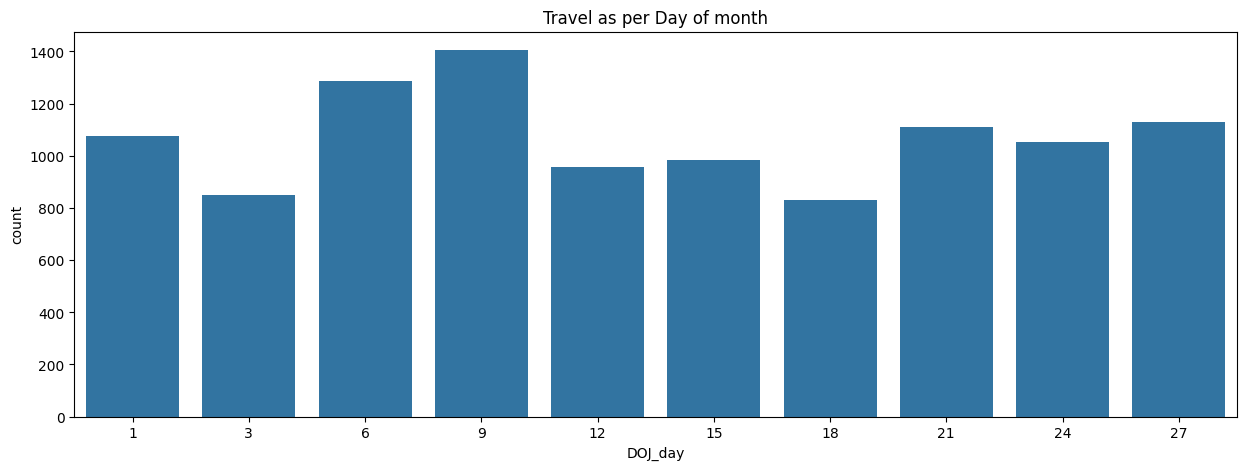

In [19]:
df['DOJ_day'] = df['Date_of_Journey'].dt.day

plt.figure(figsize=(15,5))
sns.countplot(x = df['DOJ_day'])
plt.title('Travel as per Day of month')

Text(0.5, 1.0, 'Travel as per Day of Week')

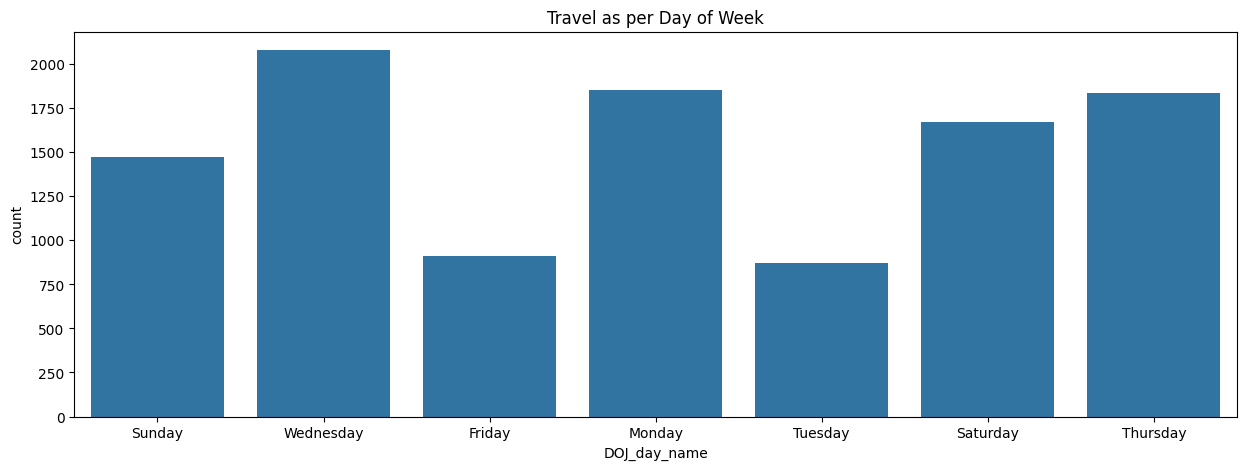

In [20]:
plt.figure(figsize=(15,5))
sns.countplot(x = df['DOJ_day_name'])
plt.title('Travel as per Day of Week')

Text(0.5, 1.0, 'Travel as per Month')

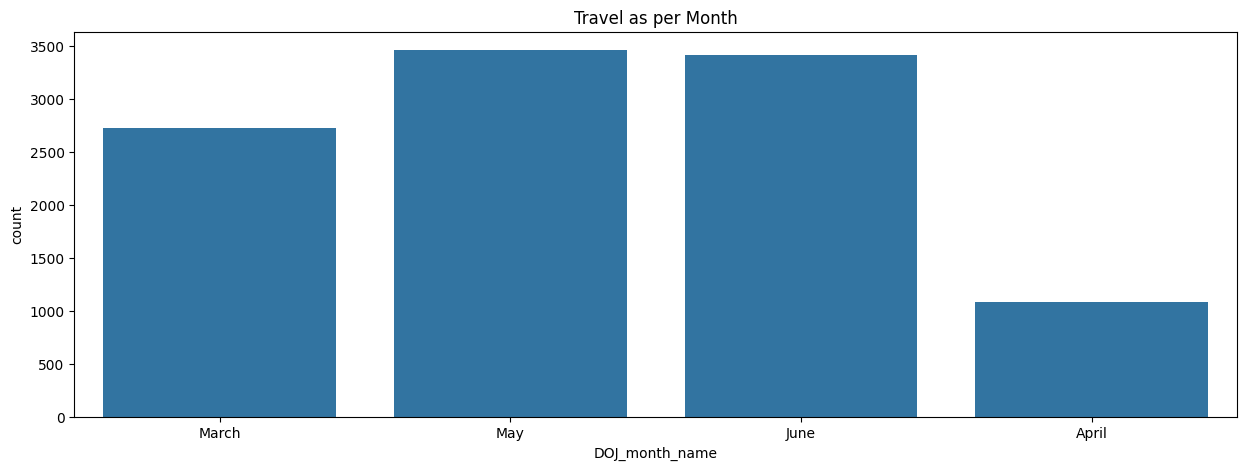

In [21]:
df['DOJ_month_name'] = df['Date_of_Journey'].dt.month_name()
plt.figure(figsize=(15,5))
sns.countplot(x = df['DOJ_month_name'])
plt.title('Travel as per Month')

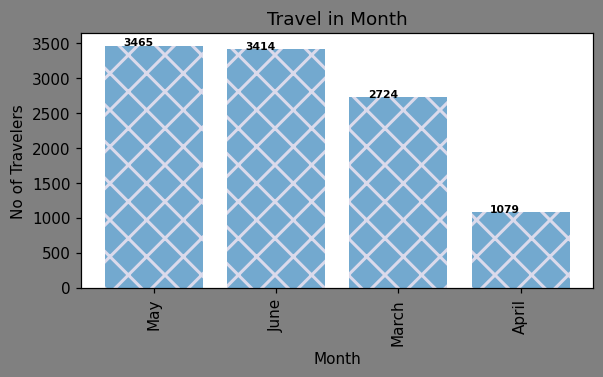

In [22]:
import pandas as pd
import matplotlib.pyplot as plt

d = df['DOJ_month_name'].value_counts().reset_index()

fig, ax = plt.subplots(figsize=(6, 3), dpi=110, facecolor='gray')
cmap = plt.get_cmap('PuBu')
plt.rcParams['hatch.color'] = cmap(0.2)
plt.rcParams['hatch.linewidth'] = 2

# Access month names using the correct column name 'DOJ_month_name'
ax.bar(d['DOJ_month_name'], d.iloc[:, 1], color=cmap(0.5), hatch="x")

for i in ax.patches:
    height = i.get_height()
    x = i.get_x()
    ax.text(x=x + 0.15, y=height, s=height, fontsize=7, fontweight='bold')

plt.xticks(rotation=90)
plt.xlabel('Month')
plt.ylabel('No of Travelers')
plt.title('Travel in Month')
plt.show()

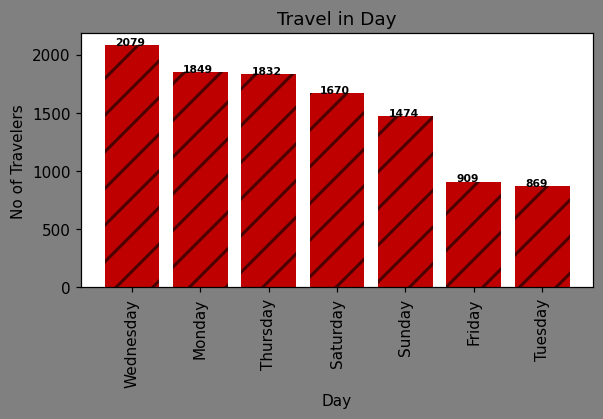

In [23]:
d = df['DOJ_day_name'].value_counts().reset_index()
fig,ax = plt.subplots(figsize=(6,3),dpi=110,facecolor='gray')
cmap=plt.get_cmap('gist_heat_r')
plt.rcParams['hatch.color'] = cmap(0.8)
plt.rcParams['hatch.linewidth'] = 2
ax.bar(d['DOJ_day_name'], d.iloc[:, 1],color=cmap(0.5),hatch="/") # hatch = any of "*+-./OX\ox|"
for i in ax.patches:
        height = i.get_height() # get height of bar (value of y axis)
        x = i.get_x() # get x_axis value
        ax.text(x=x+0.15,y=height,s=height,fontsize=7,fontweight='bold')
plt.xticks(rotation=90)
plt.xlabel('Day')
plt.ylabel('No of Travelers')
plt.title('Travel in Day')
plt.show()

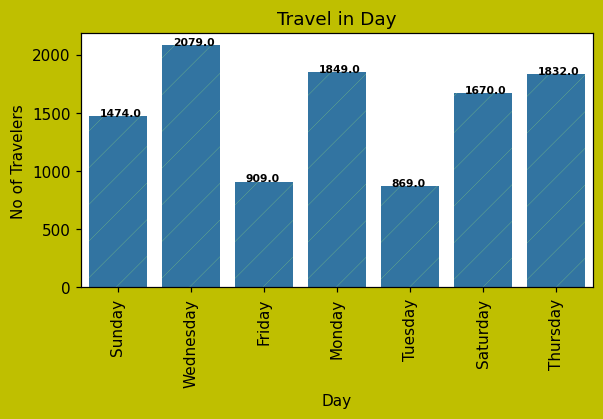

In [24]:
fig,ax = plt.subplots(figsize=(6,3),dpi=110,facecolor='y')
cmap=plt.get_cmap('Accent_r')
plt.rcParams['hatch.color'] = cmap(0.9)
plt.rcParams['hatch.linewidth'] = 0.2
ax = sns.countplot(x = df['DOJ_day_name'],hatch="/") # hatch = any of "*+-./OX\ox|"
for i in ax.patches:
        height = i.get_height() # get height of bar (value of y axis)
        x = i.get_x() # get x_axis value
        ax.text(x=x+0.15,y=height,s=height,fontsize=7,fontweight='bold')
plt.xticks(rotation=90)
plt.xlabel('Day')
plt.ylabel('No of Travelers')
plt.title('Travel in Day')
plt.show()

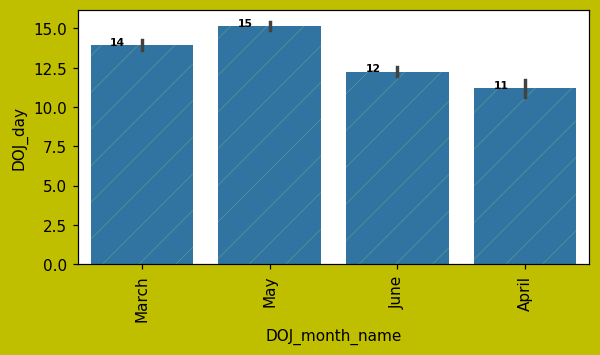

In [25]:
fig,ax = plt.subplots(figsize=(6,3),dpi=110,facecolor='y')
cmap=plt.get_cmap('Accent_r')
plt.rcParams['hatch.color'] = cmap(0.9)
plt.rcParams['hatch.linewidth'] = 0.2
ax = sns.barplot(y = df['DOJ_day'],x=df['DOJ_month_name'],hatch="/") # hatch = any of "*+-./OX\ox|"
for i in ax.patches:
        height = i.get_height() # get height of bar (value of y axis)
        x = i.get_x() # get x_axis value
        ax.text(x=x+0.15,y=height,s=round(height),fontsize=7,fontweight='bold')
plt.xticks(rotation=90)
# plt.xlabel('Day')
# plt.ylabel('No of Travelers')
# plt.title('Travel in Day')
plt.show()

Text(0.5, 1.0, 'Relationship b/w day of month and month')

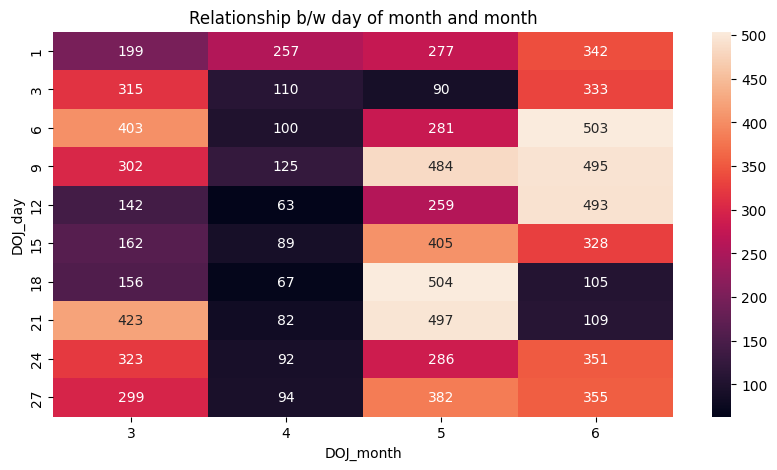

In [26]:
plt.figure(figsize=(10,5))
sns.heatmap(pd.crosstab(df['DOJ_day'],df['DOJ_month']),annot=True,fmt='')
plt.title('Relationship b/w day of month and month')

Text(0.5, 1.0, 'Relationship b/w week of the year and Month')

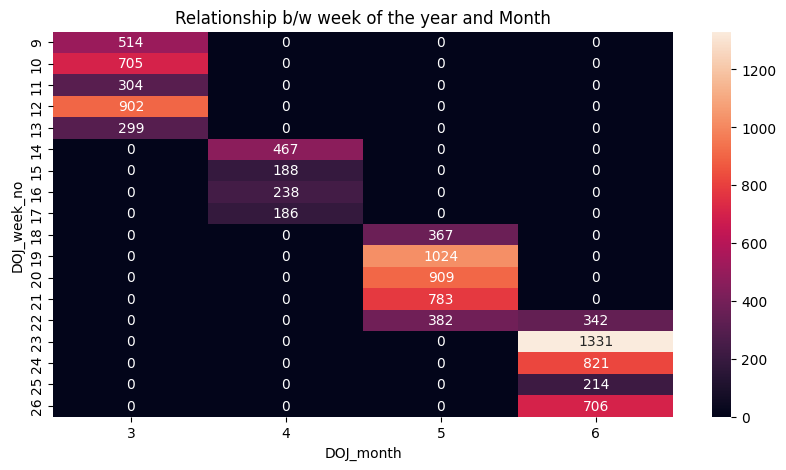

In [27]:
plt.figure(figsize=(10,5))
sns.heatmap(pd.crosstab(df['DOJ_week_no'],df['DOJ_month']),annot=True,fmt='g') # use fmt to remove scientific number notaion
plt.title('Relationship b/w week of the year and Month')

Text(0.5, 1.0, 'Relationship b/w week of the year and day of Month')

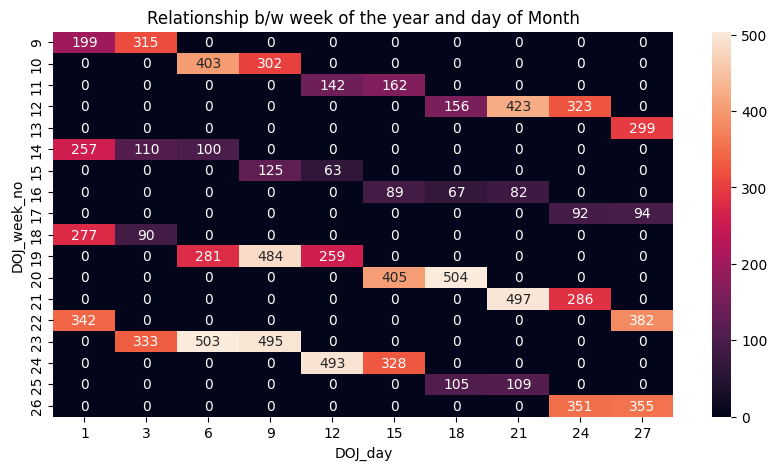

In [28]:
plt.figure(figsize=(10,5))
sns.heatmap(pd.crosstab(df['DOJ_week_no'],df['DOJ_day']),annot=True,fmt='g') # use fmt to remove scientific number notaion
plt.title('Relationship b/w week of the year and day of Month')

Text(0.5, 1.0, 'Relationship b/w week of the year and day of week')

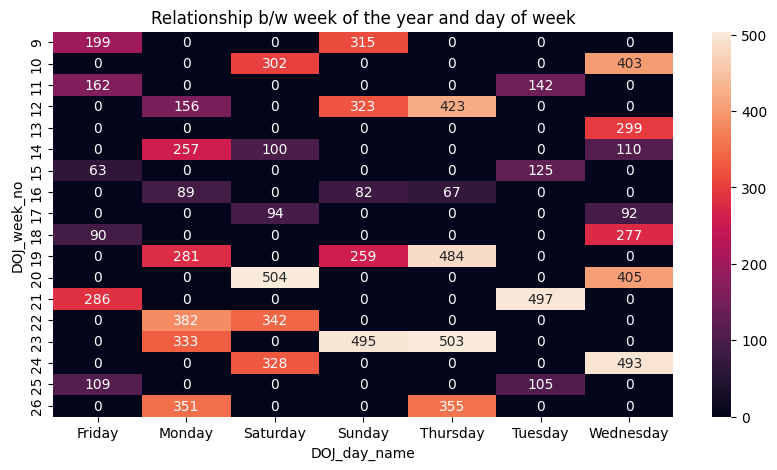

In [29]:
plt.figure(figsize=(10,5))
sns.heatmap(pd.crosstab(df['DOJ_week_no'],df['DOJ_day_name']),annot=True,fmt='g') # use fmt to remove scientific number notaion
plt.title('Relationship b/w week of the year and day of week')

Text(0.5, 1.0, 'Relationship b/w Airline and Day of month')

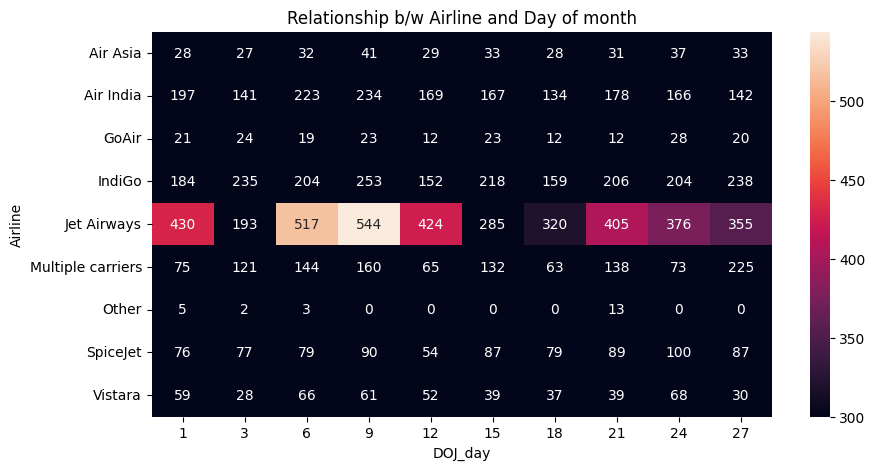

In [30]:
plt.figure(figsize=(10,5))
sns.heatmap(pd.crosstab(df['Airline'],df['DOJ_day']),annot=True,fmt='g',vmin=300)
plt.title('Relationship b/w Airline and Day of month')

Text(0.5, 1.0, 'Relationship b/w Airline and Day of week')

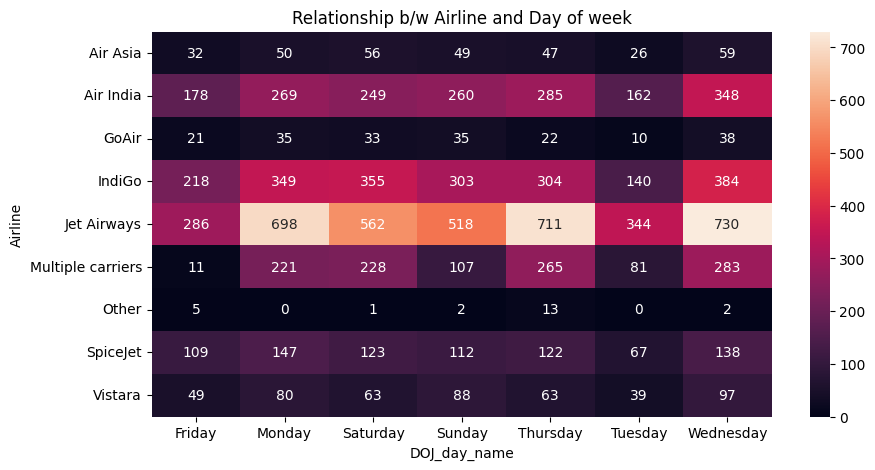

In [31]:
plt.figure(figsize=(10,5))
sns.heatmap(pd.crosstab(df['Airline'],df['DOJ_day_name']),annot=True,fmt='g')
plt.title('Relationship b/w Airline and Day of week')

Text(0.5, 1.0, 'Relationship b/w Airline and month')

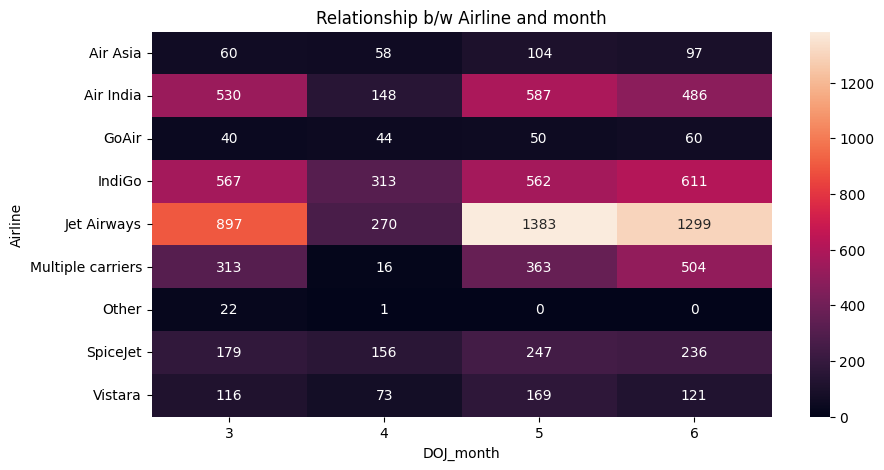

In [32]:
plt.figure(figsize=(10,5))
sns.heatmap(pd.crosstab(df['Airline'],df['DOJ_month']),annot=True,fmt='g')
plt.title('Relationship b/w Airline and month')

Text(0.5, 1.0, 'Source Count')

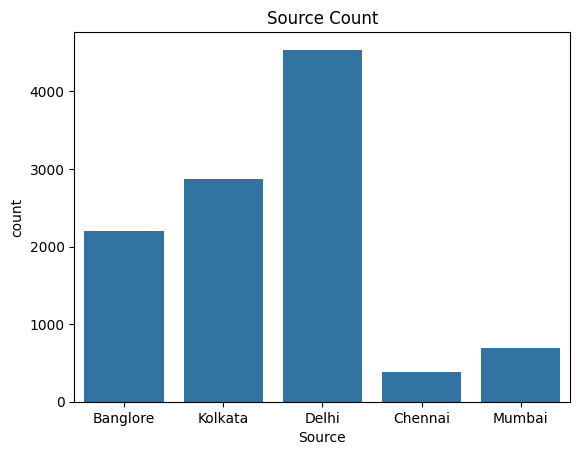

In [33]:
sns.countplot(x = df['Source'])
plt.title('Source Count')

Text(0.5, 1.0, 'Destination Count')

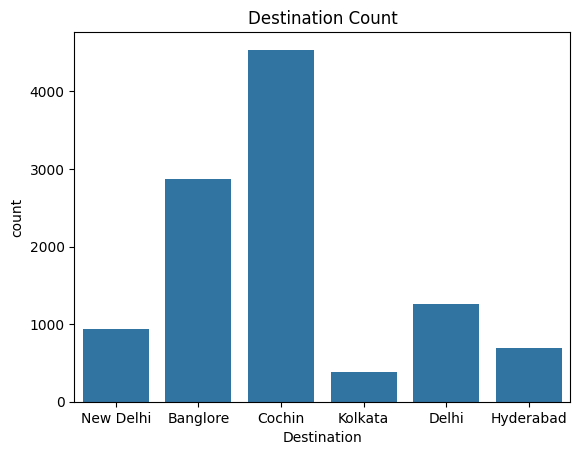

In [34]:
sns.countplot(x = df['Destination'])
plt.title('Destination Count')

In [35]:
print(df.columns)

Index(['Airline', 'Date_of_Journey', 'Source', 'Destination', 'Route',
       'Dep_Time', 'Arrival_Time', 'Duration', 'Total_Stops',
       'Additional_Info', 'Price', 'DOJ_year', 'DOJ_month', 'DOJ_month_name',
       'Day', 'DOJ_day_name', 'DOJ_week_no', 'Week of Year', 'Departure Hour',
       'Departure Min', 'Arrival Hour', 'Arrival Min', 'Duration Hour',
       'Duration Min', 'DOJ_day'],
      dtype='object')


In [36]:
drop = ['Date_of_Journey', 'Route', 'Dep_Time', 'Arrival_Time', 'Duration']
df.drop(columns=drop,inplace=True)
df.fillna(0,inplace=True)
df.drop(columns=['DOJ_month_name','DOJ_day_name'],inplace=True)
df = pd.get_dummies(df,columns=['Airline','Source','Destination','Additional_Info'],drop_first=True)
df['Duration Hour'].replace('5m',5,inplace=True)
df['Duration Hour'] = df['Duration Hour'].astype(int)
df['Duration Min'] = df['Duration Min'].astype(int)
X = df.drop(columns=['Price'])
y = df['Price']

In [37]:
X.columns

Index(['Total_Stops', 'DOJ_year', 'DOJ_month', 'Day', 'DOJ_week_no',
       'Week of Year', 'Departure Hour', 'Departure Min', 'Arrival Hour',
       'Arrival Min', 'Duration Hour', 'Duration Min', 'DOJ_day',
       'Airline_Air India', 'Airline_GoAir', 'Airline_IndiGo',
       'Airline_Jet Airways', 'Airline_Multiple carriers', 'Airline_Other',
       'Airline_SpiceJet', 'Airline_Vistara', 'Source_Chennai', 'Source_Delhi',
       'Source_Kolkata', 'Source_Mumbai', 'Destination_Cochin',
       'Destination_Delhi', 'Destination_Hyderabad', 'Destination_Kolkata',
       'Destination_New Delhi', 'Additional_Info_1', 'Additional_Info_2'],
      dtype='object')

In [38]:
non_numeric_cols = X.select_dtypes(include=["object"]).columns

In [39]:
for col in non_numeric_cols:
  non_numeric_rows = X_train[X_train[col].astype(str).str.contains("[^0-9]", na=False)]
  if not non_numeric_rows.empty:
    print(f"Non-numeric values found in column '{col}':")
    print(non_numeric_rows[col])

In [40]:
df["non_numeric_column"] = pd.Series(dtype="object")

In [41]:
df["non_numeric_column"] = 0

In [42]:
df["non_numeric_column"] = pd.to_numeric(df["non_numeric_column"], errors="coerce")

In [43]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=2)

In [44]:
lr = LinearRegression()
Decision_Tree_Regressor = DecisionTreeRegressor()
Random_Forest_Regressor = RandomForestRegressor()
Extra_Trees_Regressor = ExtraTreesRegressor()
AdaBoost_Regressor = AdaBoostRegressor()
Gradient_Boosting_Regressor = GradientBoostingRegressor()
Bagging_Regressor = BaggingRegressor()

In [45]:
model_list = [lr, Decision_Tree_Regressor,Random_Forest_Regressor,Extra_Trees_Regressor,AdaBoost_Regressor,Gradient_Boosting_Regressor,Bagging_Regressor]

In [46]:
for i in model_list:
    i.fit(X_train,y_train)
    pred = i.predict(X_test)
    print(i,"Score : ",round(i.score(X_test,y_test)*100,2),"R2 Score : ", round(r2_score(y_test,pred)*100,2))

LinearRegression() Score :  63.65 R2 Score :  63.65
DecisionTreeRegressor() Score :  85.8 R2 Score :  85.8
RandomForestRegressor() Score :  91.91 R2 Score :  91.91
ExtraTreesRegressor() Score :  91.64 R2 Score :  91.64
AdaBoostRegressor() Score :  63.81 R2 Score :  63.81
GradientBoostingRegressor() Score :  82.64 R2 Score :  82.64
BaggingRegressor() Score :  91.22 R2 Score :  91.22


In [47]:
rfr = RandomForestRegressor()
rfr.fit(X_train.values,y_train.values)
pred = rfr.predict(X_test.values)
print(round(r2_score(y_test,pred)*100,1))
features = pd.DataFrame(rfr.feature_importances_,X.columns).reset_index().sort_values(by=0)

92.0


In [48]:
fig = px.bar(features,x='index',y=0,color=0,labels={'index':'Features','0':'Value'})
fig.update_layout(title_text='Feature Importance', title_x=0.5)
fig.show()

Text(0.5, 1.0, 'Result')

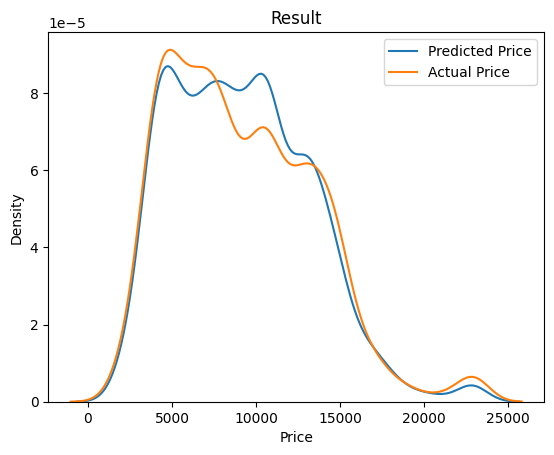

In [49]:
sns.kdeplot(pred,label='Predicted Price')
sns.kdeplot(y_test,label='Actual Price')
plt.legend()
plt.title('Result')

Text(0.5, 1.0, 'Result Error')

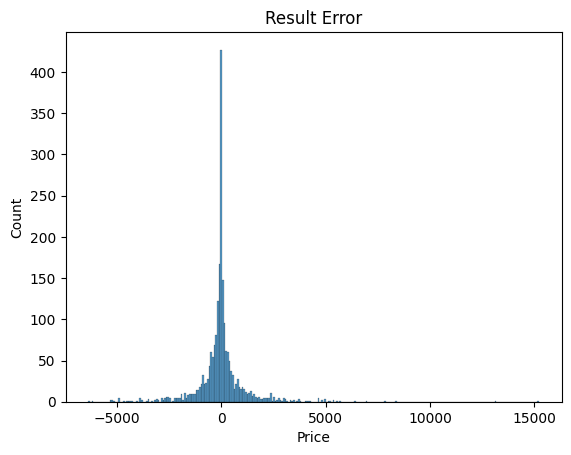

In [50]:
sns.histplot(y_test-pred)
plt.title('Result Error')

In [51]:
fig = px.histogram(x=(y_test-pred), marginal="rug")

fig.show()

Text(0.5, 1.0, 'Actual/Predicted Price')

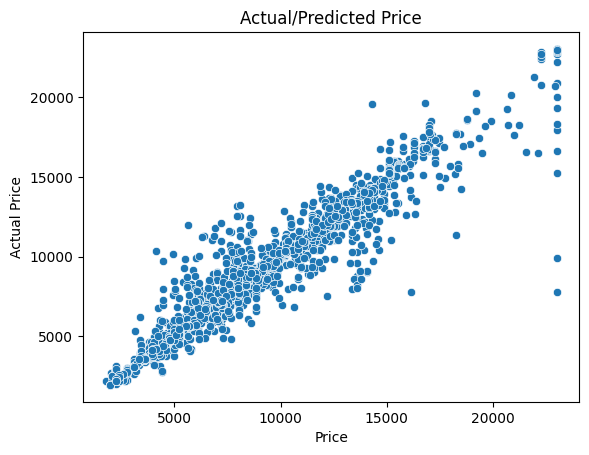

In [52]:
sns.scatterplot(x = y_test,y = pred)
plt.ylabel('Predicted Price')
plt.ylabel('Actual Price')
plt.title('Actual/Predicted Price')